<a href="https://colab.research.google.com/github/AlexLei2018/NLP/blob/main/Base_BERT_for_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.4 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
     |████████████████████████████████| 895 kB 42.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import transformers
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
train_curve = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 2
epoches = 100
model = "bert-base-uncased"
hidden_size = 768
n_class = 2
maxlen = 8

In [ ]:
# Load Dataset

In [6]:
df = pd.read_csv('label_news.csv')

In [7]:
df= df[['label', 'Body']]
df.columns=['label', 'text']
df.head()

,label,text
0,1,"""Chicagou2019s police oversight agency release..."
1,1,"""Filed under:"", ""One person was fat..."
2,1,"""Filed under:"", ""The dayu2019s fata..."
3,1,"""Filed under:"", ""A woman was fatall..."
4,1,"""Filed under:"", ""The fatal shooting..."


In [8]:
# check class distribution
df['label'].value_counts(normalize = True)

1    0.789916
0    0.210084
Name: label, dtype: float64

In [9]:
df.shape

(119, 2)

In [34]:
# Split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [11]:
sentences = train_text.to_list()

In [12]:
labels = train_labels.to_list()

In [13]:
class MyDataset(Data.Dataset):
    def __init__(self, sentences, labels=None, with_labels=True,):
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.with_labels = with_labels
        self.sentences = sentences
        self.labels = labels
    def __len__(self):
        return len(sentences)

    def __getitem__(self, index):
        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent = self.sentences[index]

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent,
                        padding='max_length',  # Pad to max_length
                        truncation=True,       # Truncate to max_length
                        max_length=maxlen,  
                        return_tensors='pt')  # Return torch.Tensor objects

        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        if self.with_labels:  # True if the dataset has labels
            label = self.labels[index]
            return token_ids, attn_masks, token_type_ids, label
        else:
            return token_ids, attn_masks, token_type_ids

In [14]:
train = Data.DataLoader(dataset=MyDataset(sentences, labels), batch_size=batch_size, shuffle=True, num_workers=1)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [15]:
# model
class BertClassify(nn.Module):
    def __init__(self):
        super(BertClassify, self).__init__()
        self.bert = AutoModel.from_pretrained(model, output_hidden_states=True, return_dict=True)
        self.linear = nn.Linear(hidden_size, n_class)
        self.dropout = nn.Dropout(0.5)
  
    def forward(self, X):
        input_ids, attention_mask, token_type_ids = X[0], X[1], X[2]
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids) # return a output dict
        # the last layer cls vector for classification
        # outputs.pooler_output: [bs, hidden_size]
        logits = self.linear(self.dropout(outputs.pooler_output))

        return logits

In [16]:
bc = BertClassify().to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
optimizer = optim.Adam(bc.parameters(), lr=1e-3, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [39]:
%time
# train
sum_loss = 0
total_step = len(train)
for epoch in range(epoches):
    for i, batch in enumerate(train):
        optimizer.zero_grad()
        batch = tuple(p.to(device) for p in batch)
        pred = bc([batch[0], batch[1], batch[2]])
        loss = loss_fn(pred, batch[3])
        sum_loss += loss.item()

        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print('[{}|{}] step:{}/{} loss:{:.4f}'.format(epoch+1, epoches, i+1, total_step, loss.item()))
    train_curve.append(sum_loss)
    sum_loss = 0

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
[1|100] step:1/42 loss:0.2572
[1|100] step:2/42 loss:0.8746
[1|100] step:3/42 loss:0.2529
[1|100] step:4/42 loss:0.2505
[1|100] step:5/42 loss:0.2469
[1|100] step:6/42 loss:0.8897
[1|100] step:7/42 loss:0.2399
[1|100] step:8/42 loss:0.2365
[1|100] step:9/42 loss:0.9036
[1|100] step:10/42 loss:0.2302
[1|100] step:11/42 loss:0.2272
[1|100] step:12/42 loss:0.9168
[1|100] step:13/42 loss:0.2217
[1|100] step:14/42 loss:0.9224
[1|100] step:15/42 loss:0.2196
[1|100] step:16/42 loss:1.6286
[1|100] step:17/42 loss:0.2240
[1|100] step:18/42 loss:0.2274
[1|100] step:19/42 loss:0.2289
[1|100] step:20/42 loss:0.2287
[1|100] step:21/42 loss:0.9103
[1|100] step:22/42 loss:0.2279
[1|100] step:23/42 loss:1.5939
[1|100] step:24/42 loss:0.9042
[1|100] step:25/42 loss:0.8962
[1|100] step:26/42 loss:0.2440
[1|100] step:27/42 loss:0.2487
[1|100] step:28/42 loss:0.2515
[1|100] step:29/42 loss:0.2525
[1|100] step:30/42 loss:0.8768
[1|100] step:31/

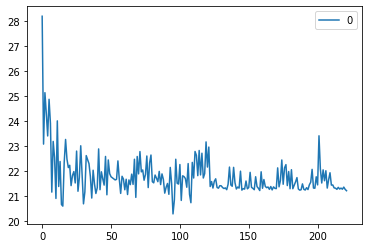

In [40]:
pd.DataFrame(train_curve).plot() # loss curve line

In [44]:
# test
bc.eval()
with torch.no_grad():
    test_text1 = [test_text.to_list()[5]]
    test_labels1 = [test_labels .to_list()[5]]
    test = MyDataset(test_text1, labels=None, with_labels=False)
    x = test.__getitem__(0)
    x = tuple(p.unsqueeze(0).to(device) for p in x)
    pred = bc([x[0], x[1], x[2]])
    pred = pred.data.max(dim=1, keepdim=True)[1]
    if pred[0][0] == 0:
        print('nocrime news')
        print('real label: ', test_labels1[0])  # 1. crime news, 0. nocrime news
    elif pred[0][0] == 1:
        print('crime news')
        print('real label: ', test_labels1[0])

crime news
real label:  1


In [42]:
type(test_text)

pandas.core.series.Series

In [45]:

# test
bc.eval()
with torch.no_grad():
    labels = []
    aa = test_text.to_list()
    bb = test_labels.to_list()
    for i in range(len(aa)):
        

        test_text1 = [aa[i]]
        test_labels1 = [bb[i]]
        test = MyDataset(test_text1, labels=None, with_labels=False)
        x = test.__getitem__(0)
        x = tuple(p.unsqueeze(0).to(device) for p in x)
        pred = bc([x[0], x[1], x[2]])
        pred = pred.data.max(dim=1, keepdim=True)[1]
        if pred[0][0] == 0:
            print('nocrime news')
            print('real label: ', test_labels1[0])  # 1. crime news, 0. nocrime news
        elif pred[0][0] == 1:
            print('crime news')
            print('real label: ', test_labels1[0])

        labels.append(pred[0][0])


crime news
real label:  1
crime news
real label:  1
crime news
real label:  1
crime news
real label:  1
crime news
real label:  1
crime news
real label:  1
crime news
real label:  1
crime news
real label:  0
crime news
real label:  1
crime news
real label:  1
crime news
real label:  0
crime news
real label:  1
crime news
real label:  0
crime news
real label:  1
crime news
real label:  1
crime news
real label:  1
crime news
real label:  0
crime news
real label:  1


In [38]:
labels

[tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0')]

In [ ]:
## All news is labeled as crime news. The model needs to be improved.